In [1]:
import sys
sys.path.append("..")

from Code.ResidualAttentionNetwork import ResidualAttentionNetwork

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

import h5py

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import optimizers

from keras.models import load_model

/opt/packages/python/gnu_openmpi/3.6.4_np1.14.5/lib/python3.6/site-packages/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.
/opt/packages/TensorFlow/gnu/tf1.8_py3_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/packages/TensorFlow/gnu/tf1.8_py3_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/packages/TensorFlow/gnu/tf1.8_py3_gpu/lib/python3.6/site-

# Network Metadata 

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1
IMAGE_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
batch_size=32

epochs = 200

num_classes = 4

# Image Generators

For data, download from Kaggle: https://www.kaggle.com/paultimothymooney/kermany2018

In [3]:
train_dir = "/pylon5/cc5614p/deopha32/eye_images/train"
test_dir = "/pylon5/cc5614p/deopha32/eye_images/test"

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.33
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir, 
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    directory=train_dir, 
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    color_mode='grayscale',
    batch_size=batch_size,
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    shuffle=False,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
)

Found 55940 images belonging to 4 classes.
Found 27549 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [6]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [7]:
model_path = "../Saved_Model/eye-disorder-model.h5"

early_stop = EarlyStopping(monitor='val_acc',  verbose=1, patience=10)
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True)
csv_logger = CSVLogger("model_history_log.csv", append=True)

callbacks = [early_stop, checkpoint, csv_logger]

# Initial Model Training

In [8]:
# with tf.device('/gpu:0'):
#     model = ResidualAttentionNetwork(
#                 input_shape=IMAGE_SHAPE, 
#                 n_classes=num_classes, 
#                 activation='softmax').build_model()

#     model.compile(optimizer=optimizers.Adam(lr=0.0001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit_generator(generator=train_generator,
#                         steps_per_epoch=STEP_SIZE_TRAIN, verbose=1, callbacks=callbacks,
#                         validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
#                         epochs=epochs, use_multiprocessing=True, workers=32)

# model.save(model_path)

# Load Model and Resume Training

In [9]:
with tf.device('/gpu:0'):
    model = load_model(model_path)

    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN, verbose=1, callbacks=callbacks,
                        validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, use_multiprocessing=True, workers=40, initial_epoch=50)

Epoch 51/200
1748/1748 [==============================] - 624s 357ms/step - loss: 0.4247 - acc: 0.8458 - val_loss: 0.4716 - val_acc: 0.8332

Epoch 00051: val_acc improved from -inf to 0.83318, saving model to ../Saved_Model/eye-disorder-model.h5
Epoch 52/200
1748/1748 [==============================] - 510s 292ms/step - loss: 0.4235 - acc: 0.8464 - val_loss: 0.4874 - val_acc: 0.8149

Epoch 00052: val_acc did not improve from 0.83318
Epoch 53/200
1748/1748 [==============================] - 519s 297ms/step - loss: 0.4208 - acc: 0.8475 - val_loss: 0.4756 - val_acc: 0.8252

Epoch 00053: val_acc did not improve from 0.83318
Epoch 54/200
1748/1748 [==============================] - 602s 344ms/step - loss: 0.4199 - acc: 0.8478 - val_loss: 0.4596 - val_acc: 0.8283

Epoch 00054: val_acc did not improve from 0.83318
Epoch 55/200
1748/1748 [==============================] - 598s 342ms/step - loss: 0.4168 - acc: 0.8477 - val_loss: 0.4648 - val_acc: 0.8289

Epoch 00055: val_acc did not improve fro

In [13]:
model.save(model_path)

# Visualize Data 

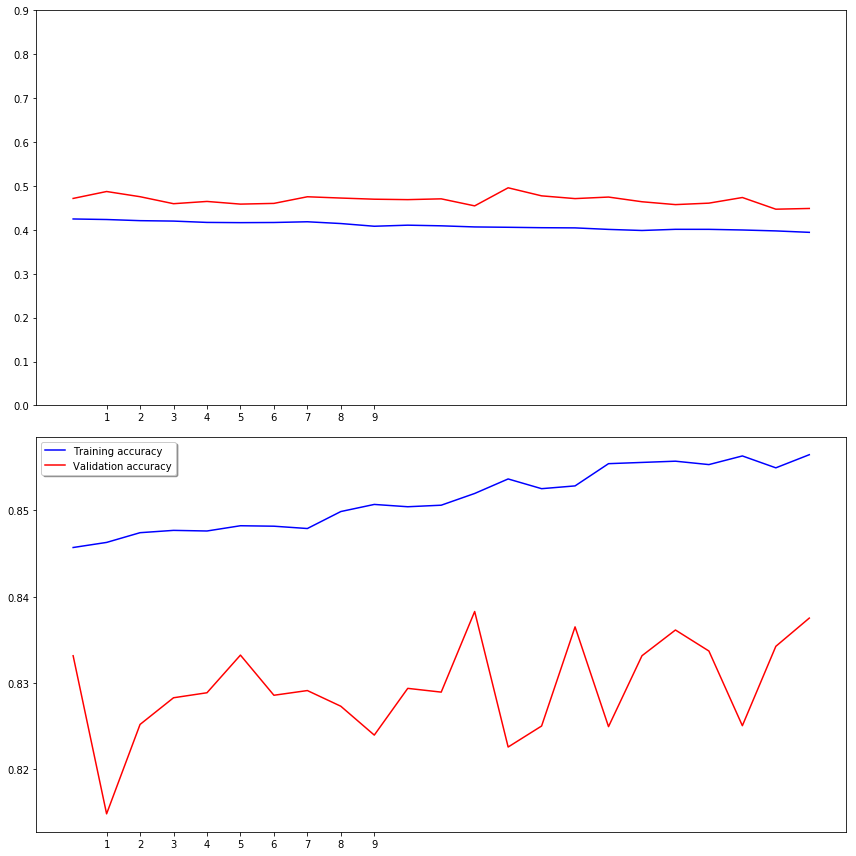

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 10, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Evaluate Model on Validation Data

In [12]:
loss, accuracy = model.evaluate_generator(valid_generator, STEP_SIZE_VALID, verbose=1, use_multiprocessing=True, workers=40)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

860/860 [==============================] - 187s 218ms/step
Test: accuracy = 0.835719  ;  loss = 0.453460 
